In [1]:
from vis.visualization import visualize_saliency
from keras import Model
from model import unet, aunet, regression_net
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
import numpy as np
import nibabel as nib

Using TensorFlow backend.
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hasee007

In [2]:
# min max scaler
def min_max_scaler(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))


# crop roi for unet prediction
def crop_roi(img):
    test_img = np.rot90(min_max_scaler(img))
    crop_img = test_img[130:130 + 160, 50:50 + 224]
    return crop_img

In [3]:
data_root = 'example/data'
model_path = 'example/model'
result_path = 'example/result'
mask_path = 'example/mask'

In [4]:
input_path = os.path.join(data_root, './')
method_path = os.path.join(model_path, 'unet_attention_300_1e4_fl_25.hdf5')
method_net = unet(pretrained_weights=method_path)
result_method='aunet'


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
data_filename = '0507_90day50u_20190812_mouse51SWI.nii'
data_path = os.path.join(data_root, data_filename)
mask_filename = os.path.join(mask_path, '51.nii')
result_filename = os.path.join(result_path, '{}_detect_by_{}.nii'.format(data_filename.split('.')[-2], result_method))
print('Data: {}\nGround True: {}\nResult: {}\n'.format(data_path, mask_filename, result_filename))

Data: example/data\0507_90day50u_20190812_mouse51SWI.nii
Ground True: example/mask\51.nii
Result: example/result\0507_90day50u_20190812_mouse51SWI_detect_by_aunet.nii



In [6]:
data = nib.load(data_path)
mask = nib.load(mask_filename)
result = nib.load(result_filename)

In [7]:
data_matrix = data.get_data()
pred_matrix = result.get_data()
gt_matrix = mask.get_data()

In [29]:
frame_num = 20
threshold = 0.50

In [30]:
img = data_matrix[:, :, frame_num]
gt = gt_matrix[:, :, frame_num]
pred = pred_matrix[:, :, frame_num]

In [31]:
from vis.visualization import visualize_saliency
from vis.utils import utils

In [32]:
layer_idx = len(method_net.layers) - 1
crop_img = crop_roi(img)
crop_gt = crop_roi(gt)
crop_pred = crop_roi(pred)
crop_img = np.reshape(crop_img, crop_img.shape + (1,))

In [33]:
saliency_map = visualize_saliency(model=method_net, layer_idx=layer_idx, filter_indices=0, seed_input=crop_img)
thres_map = np.zeros_like(saliency_map)
thres_map[saliency_map > threshold] = 1

In [34]:
import cv2
pred_num, _ = cv2.connectedComponents(np.uint8(thres_map))

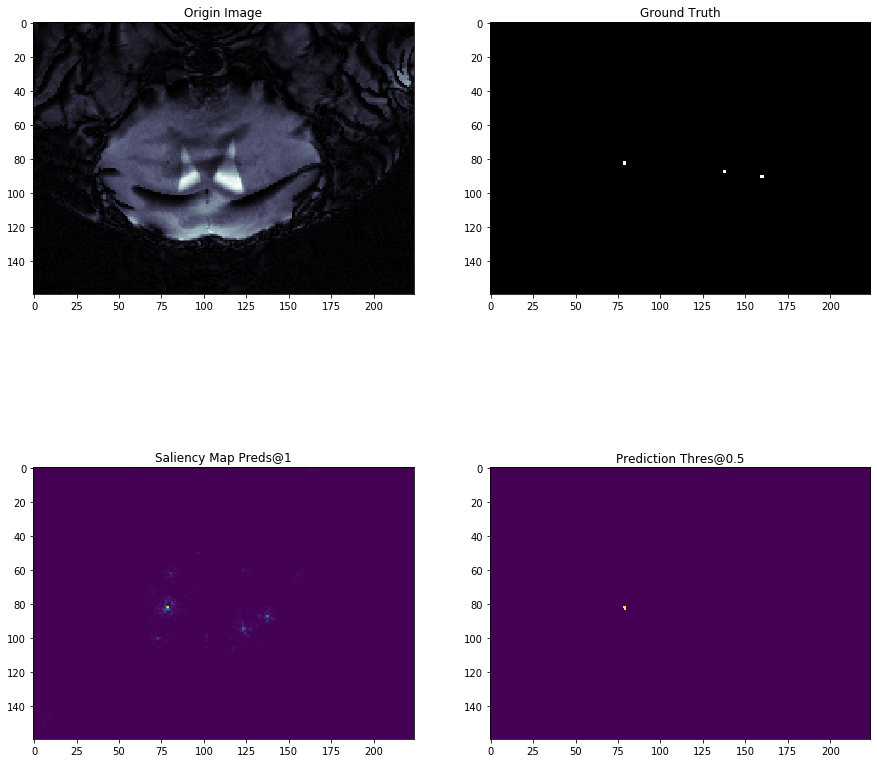

In [35]:
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.title('Origin Image')
plt.imshow(crop_img[:, :, 0], cmap='bone')
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(crop_gt, cmap='bone')
plt.subplot(223)
plt.title('Saliency Map Preds@{}'.format(pred_num - 1))
plt.imshow(saliency_map)
plt.subplot(224)
plt.title('Prediction Thres@{}'.format(threshold))
plt.imshow(thres_map)

In [7]:
NII_fileList = []
for dirName, subdirList, fileList in os.walk(input_path):
    for filename in fileList:
        if ".nii" in filename.lower():
            # print filename
            NII_fileList.append(os.path.join(dirName, filename))

In [22]:
for file in tqdm(NII_fileList, desc='Detect in {}'.format(os.path.abspath(input_path))):
    filename = os.path.basename(file)
    #_, _ = detect_file(file, model, layer_net)
    data = nib.load(file)
    
    width, height, frame_num = data.shape
    matrix = data.get_data()
    #unet_matrix = bet_unet(matrix, layer_net, threshold=0.2)
    img_batch = np.transpose(matrix, (2, 0, 1))
    #mask_batch = unet_batch_predict(img_batch, layer_net, threshold=0.2)
    batch, h, w = img_batch.shape
    crop_batch = []
    for img in img_batch:
        crop_img = crop_roi(img)
        crop_batch.append(crop_img)
    crop_batch = np.array(crop_batch)
    crop_batch = np.reshape(crop_batch, crop_batch.shape + (1,))
    
saliency_map = visualize_saliency(model=method_net, layer_idx=41, seed_input=crop_batch, filter_indices=0)

Detect in F:\GitHub\DICOM\example\data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.85it/s]
